In [36]:
# Importing Libraries 
import cv2
import numpy as np 
import os 
import pickle 
from matplotlib import pyplot as plt
%matplotlib inline 


In [37]:
# Defining Image Paths 
images_left_dir = 'assignment2_stereodata/images_left'
images_right_dir = 'assignment2_stereodata/images_right'

In [38]:
# Function for feature inlier feature detection

def SIFT_feature_match(im_left, im_right):

    sift = cv2.SIFT_create()

    # Extract features
    kp1, des1 = sift.detectAndCompute(im_left, None) 
    kp2, des2 = sift.detectAndCompute(im_right, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

    # Perform matching using extracted descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])


    # Find inliers 
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

    # retain only points which were inliers (specified by "mask")
    pts1_inliers = pts1[mask[:,0]==1]
    pts2_inliers = pts2[mask[:,0]==1]

    return pts1_inliers, pts2_inliers



In [81]:
# Function for feature inlier feature detection

def ORB_feature_match(im_left, im_right, num_features):

    orb = cv2.ORB_create(nfeatures=num_features) # "nfeatures" controls the sensitivity of how many features we want to extract
    kp1, des1 = orb.detectAndCompute(im_left, None) # second parameter is a mask image (only extract points inside mask)
    kp2, des2 = orb.detectAndCompute(im_right, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

    # Perform matching using extracted descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])


    # Find inliers 
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC, ransacReprojThreshold=1.0)

    # retain only points which were inliers (specified by "mask")
    pts1_inliers = pts1[mask[:,0]==1]
    pts2_inliers = pts2[mask[:,0]==1]

    return pts1_inliers, pts2_inliers



[[[ 9.97634265e-01  9.96607168e-01  9.91994315e-01  9.92151531e-01
    9.82607130e-01  9.88521616e-01  9.83329454e-01  9.84260491e-01
    9.94206201e-01  9.94413678e-01  9.94712825e-01  9.90999674e-01
    9.87380262e-01  9.79166572e-01  9.84342720e-01  9.83463896e-01
    9.59982735e-01  9.50583555e-01  9.80181052e-01  9.83558120e-01
    9.75880910e-01  9.63886122e-01  9.59135970e-01  9.58305680e-01
    9.57708549e-01  9.60447813e-01  9.65927648e-01  9.68786559e-01
    9.67964669e-01  9.65235673e-01  9.57733961e-01  9.54284326e-01
    9.44194182e-01  9.36983181e-01  9.23746588e-01  9.19590815e-01
    9.23420639e-01  9.21316679e-01  9.21533341e-01  9.26287425e-01
    9.32101349e-01  9.30014937e-01  9.26032667e-01  9.09778803e-01
    8.66965074e-01  8.64645569e-01  8.50162366e-01  8.31465833e-01
    8.47606750e-01]
  [ 6.36894885e-02  7.48018144e-02  7.58313997e-02  1.02117351e-01
    8.18648989e-02  9.91041134e-02  1.54083708e-01  1.75824935e-01
    1.07417509e-01  1.04390657e-01  9.8825

Text(0.5, 0.92, 'Reference Terrain Model')

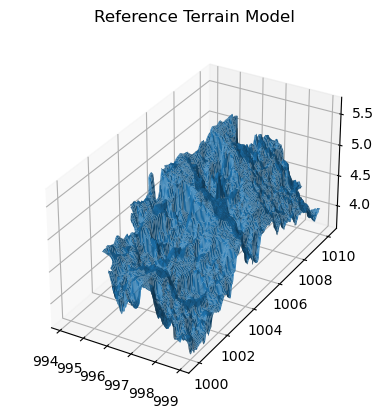

In [ ]:
# Read in the Calibration Results 
with open('assignment2_stereodata/camera_pose_data.pkl', 'rb') as file:
    camera_pose_data = pickle.load(file)

R_camera = camera_pose_data["R"]
t_camera = camera_pose_data["t"]
filenames_left = camera_pose_data["filenames_left"]
filenames_right = camera_pose_data["filenames_right"]

print(R_camera)
print(t_camera)


# Read in Stereo Calibration Data
with open('assignment2_stereodata/calib_stereo_diver.pkl', 'rb') as file:
    calibration_data = pickle.load(file)

D_left = calibration_data["Dl"]
K_left = calibration_data["Kl"]
D_right = calibration_data["Dr"]
K_right = calibration_data["Kr"]
R = calibration_data["R"]
t = calibration_data["t"]


# Read in the Terrain Data 
with open('assignment2_stereodata/terrain_data.pkl', 'rb') as file:
    terrain_data = pickle.load(file)

height_grid = terrain_data["height_grid"]
X = terrain_data["X"]
Y = terrain_data["Y"]





# Plot the Ground Truth Terrain Data 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 2, 1]) 

X, Y = np.meshgrid(terrain_data['X'], terrain_data['Y'])
surf = ax.plot_surface(X, Y, -terrain_data['height_grid'], rstride=5, cstride=5)
ax.set_title("Reference Terrain Model")

In [41]:
# Creating arrays to store left and right images 

left_imgs = []
for image_name in filenames_left:
    # left_imgs.append(cv2.imread(os.path.join(images_left_dir, image_name), cv2.IMREAD_GRAYSCALE))
    left_imgs.append(cv2.imread(os.path.join(images_left_dir, image_name)))


right_imgs = []
for image_name in filenames_right:
    # right_imgs.append(cv2.imread(os.path.join(images_right_dir, image_name), cv2.IMREAD_GRAYSCALE))
    right_imgs.append(cv2.imread(os.path.join(images_right_dir, image_name)))



found 2000 and 2000 feature points ...


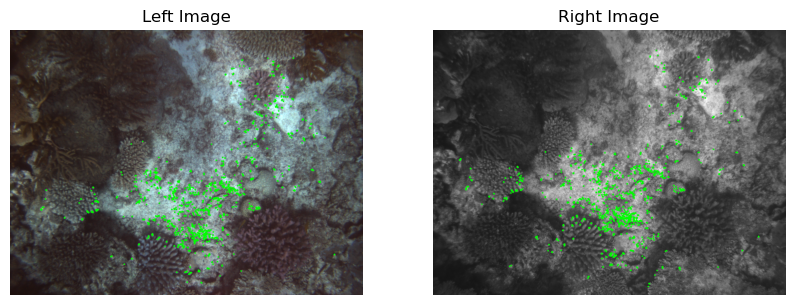

In [42]:
# Extract features - ORB

im_left = left_imgs[20]
im_right = right_imgs[20]

orb = cv2.ORB_create(nfeatures=2000) # "nfeatures" controls the sensitivity of how many features we want to extract
kp1, des1 = orb.detectAndCompute(im_left, None) # second parameter is a mask image (only extract points inside mask)
kp2, des2 = orb.detectAndCompute(im_right, None)
print('found %d and %d feature points ...'%(len(kp1),len(kp2)))
# kp: keypoints (image location of feature), des: descriptor: ORB feature descriptor for each keypoint

# draw located keypoints
# imglc = cv2.cvtColor(left_imgs[20], cv2.COLOR_GRAY2RGB)
# imgrc = cv2.cvtColor(right_imgs[20], cv2.COLOR_GRAY2RGB)
imglc = cv2.cvtColor(left_imgs[20], cv2.COLOR_BGR2RGB)
imgrc = cv2.cvtColor(right_imgs[20], cv2.COLOR_BGR2RGB)
for k in kp1:
    cv2.circle(imglc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)
for k in kp2:
    cv2.circle(imgrc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc,'Greys')
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc,'Greys')
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()

Found 1063 matches ...


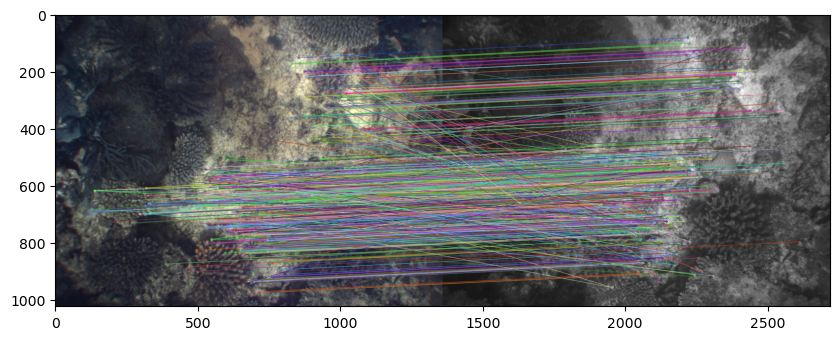

In [43]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Found 832 inlier correspondances


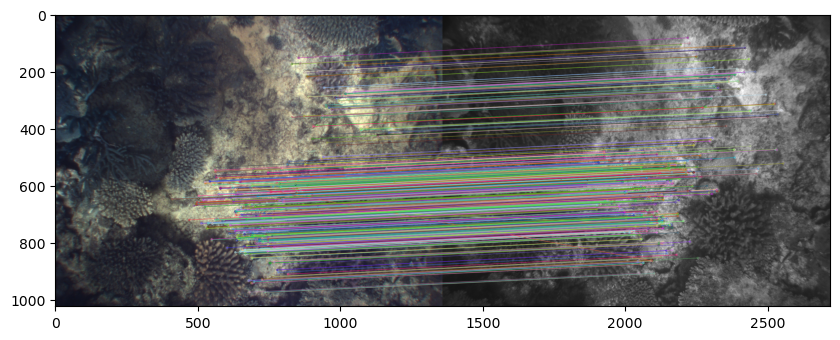

In [44]:
# Implementing Outlier Rejection 
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

found 8205 and 7775 feature points ...


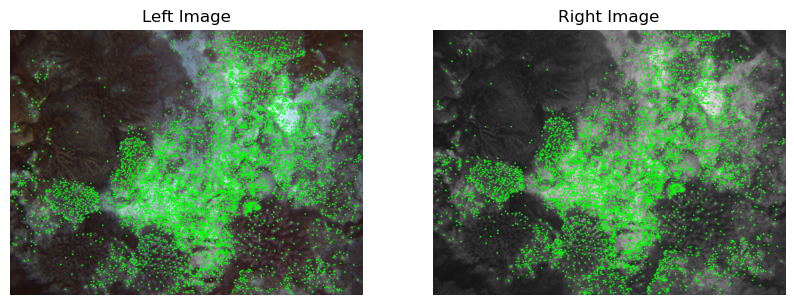

In [45]:
# SIFT FEATURE DETECTION 

im_left = left_imgs[20]
im_right = right_imgs[20]

sift = cv2.SIFT_create()

# Extract features
kp1, des1 = sift.detectAndCompute(im_left, None) 
kp2, des2 = sift.detectAndCompute(im_right, None)

print('found %d and %d feature points ...' % (len(kp1), len(kp2)))

# Draw located keypoints
# imglc = cv2.cvtColor(im_left, cv2.COLOR_GRAY2RGB)
# imgrc = cv2.cvtColor(im_right, cv2.COLOR_GRAY2RGB)
imglc = cv2.cvtColor(left_imgs[20], cv2.COLOR_BGR2RGB)
imgrc = cv2.cvtColor(right_imgs[20], cv2.COLOR_BGR2RGB)
for k in kp1:
    cv2.circle(imglc, (int(k.pt[0]), int(k.pt[1])), 3, (0, 255, 0), -1)
for k in kp2:
    cv2.circle(imgrc, (int(k.pt[0]), int(k.pt[1])), 3, (0, 255, 0), -1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc)
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc)
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()


Found 5118 matches ...


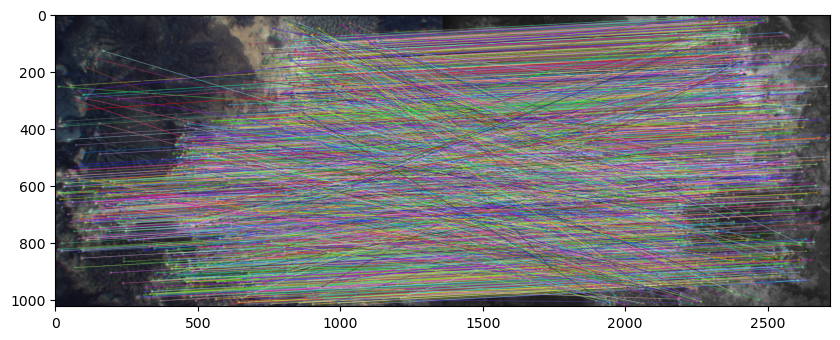

In [46]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Found 4612 inlier correspondances


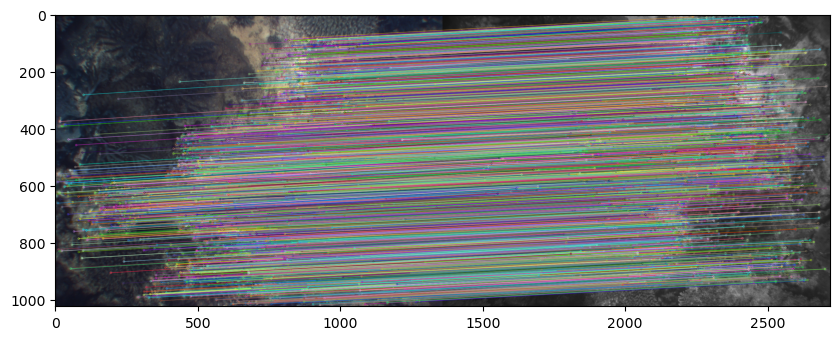

In [47]:
# Implementing Outlier Rejection 
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

In [ ]:
# Run feature detector on all stereo image pairs 
 
# all_left_points = []
# all_right_points =[]

# for i in range(len(left_imgs)):
#     im_left = left_imgs[i]
#     im_right = right_imgs[i]
#     left_points, right_points = SIFT_feature_match(im_left, im_right)

#     all_left_points.append(left_points)
#     all_right_points.append(right_points)


# all_right_points = np.array(np.vstack(all_right_points))
# all_left_points = np.array(np.vstack(all_left_points))





<Figure size 640x480 with 0 Axes>

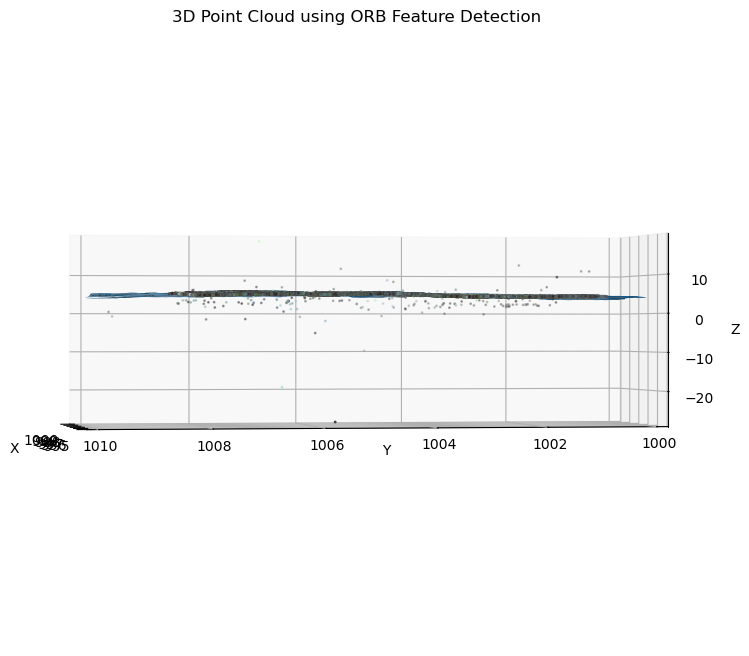

In [76]:
############################################ GENERATE 3D MAP USING ORB FEATURE DETECTION #################################################
 
pixel_colours = []
world_points = []

num_features = 1000


P_left = (K_left)@ np.hstack((np.eye(3), np.zeros((3, 1)))) 
P_right = (K_right) @ np.hstack((R, t))  

for i in range(len(left_imgs)):
    im_left = left_imgs[i]
    im_right = right_imgs[i]
    im_left = cv2.cvtColor(im_left, cv2.COLOR_BGR2RGB)
    im_right = cv2.cvtColor(im_right, cv2.COLOR_BGR2RGB)

    left_points, right_points = SIFT_feature_match(im_left, im_right)


    for point in left_points: 
        x, y = point

        x = int(x)
        y = int(y)

        colour = im_left[y, x]  
        pixel_colours.append(colour)


    pts1_h = left_points.T.astype(np.float32)
    pts2_h = right_points.T.astype(np.float32)

    points_4D = cv2.triangulatePoints(P_left, P_right, pts1_h, pts2_h)
    points_3D = points_4D/points_4D[3]
    points_3D = points_3D[:3,:]


    # Transform into world coordinates 
    R_wc = R_camera[:, :, i]  
    t_wc = t_camera[:, i] 

    R_cw = R_wc.T
    t_cw = -R_cw @ t_wc.reshape(3, 1)

    points_world = (R_cw @ points_3D + t_cw).T 
    world_points.append(points_world)

pixel_colours = np.array(np.vstack(pixel_colours))
world_points = np.array(np.vstack(world_points))


# Generating 3D terrain map 
fig = plt.figure()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(terrain_data['X'], terrain_data['Y'])
surf = ax.plot_surface(X, Y, -terrain_data['height_grid'], rstride=5, cstride=5)
ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2], s=1, c=pixel_colours/255.0)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1, 3, 1]) 
ax.view_init(elev=0, azim=170) 
ax.set_xlim([995, 1000])
ax.set_ylim([1000, 1010])
# ax.set_zlim([-5, 6])
ax.set_title("3D Point Cloud using ORB Feature Detection")
plt.show()

<Figure size 640x480 with 0 Axes>

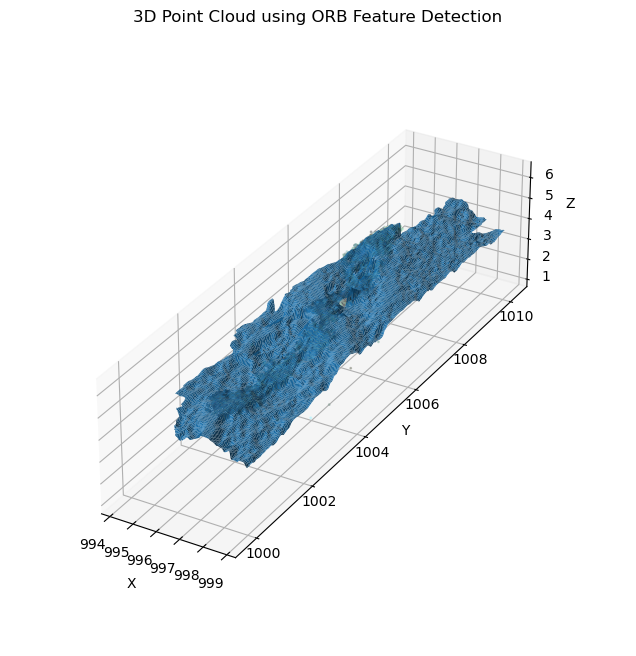

In [86]:
############################################ GENERATE 3D MAP USING ORB FEATURE DETECTION #################################################
 
pixel_colours = []
world_points = []

num_features = 3000


P_left = (K_left)@ np.hstack((np.eye(3), np.zeros((3, 1)))) 
P_right = (K_right) @ np.hstack((R, t))  

for i in range(len(left_imgs)):
    im_left = left_imgs[i]
    im_right = right_imgs[i]
    im_left = cv2.cvtColor(im_left, cv2.COLOR_BGR2RGB)
    im_right = cv2.cvtColor(im_right, cv2.COLOR_BGR2RGB)

    left_points, right_points = ORB_feature_match(im_left, im_right, num_features)


    for point in left_points: 
        x, y = point

        x = int(x)
        y = int(y)

        colour = im_left[y, x]  
        pixel_colours.append(colour)


    pts1_h = left_points.T.astype(np.float32)
    pts2_h = right_points.T.astype(np.float32)

    points_4D = cv2.triangulatePoints(P_left, P_right, pts1_h, pts2_h)
    points_3D = points_4D/points_4D[3]
    points_3D = points_3D[:3,:]


    # Transform into world coordinates 
    R_wc = R_camera[:, :, i]  
    t_wc = t_camera[:, i] 

    R_cw = R_wc.T
    t_cw = -R_cw @ t_wc.reshape(3, 1)

    points_world = (R_cw @ points_3D + t_cw).T 
    world_points.append(points_world)

pixel_colours = np.array(np.vstack(pixel_colours))
world_points = np.array(np.vstack(world_points))


# Generating 3D terrain map 
fig = plt.figure()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(terrain_data['X'], terrain_data['Y'])
surf = ax.plot_surface(X, Y, -terrain_data['height_grid'], rstride=5, cstride=5)
ax.scatter(world_points[:, 0], world_points[:, 1], world_points[:, 2], s=1, c=pixel_colours/255.0)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_box_aspect([1, 4, 1]) 
# ax.view_init(elev=0, azim=170) 
# ax.set_xlim([995, 1000])
# ax.set_ylim([1000, 1010])
# ax.set_zlim([-5, 6])
ax.set_title("3D Point Cloud using ORB Feature Detection")
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1, 2, 1]) 


# ax.set_title("Reference Terrain Model")